<h1>Project: classify (binary) chest X-ray iamges</h1>

__Description__: given a set of annotated chest X-ray images, develop a model to classify images into two classes: normal or pneumonia.

__Dataset__: dataset consists of 5858 annotated Chest X-ray images, in which the anateror-posteriors were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou ([ref.](https://data.mendeley.com/datasets/rscbjbr9sj/3).
- trainset: 3883 pneumonia, 1349 normal
- testset: 390 pneumonia, 234 normal

# Dataset and packages

In [10]:
import numpy as np; import pandas as pd

from PIL import Image
from IPython.display import display
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import os, gc, cv2
from tqdm import tqdm
import torch; import torchvision

import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

from torchvision import transforms, models, datasets

try:
  from torchinfo import summary
except:
  !pip install torchinfo -q
  from torchinfo import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


## Load dataset

In [2]:
root_train = '/content/drive/MyDrive/Projects/ComputerVision/data/ChestXray/chest_xray/train/'
root_test = '/content/drive/MyDrive/Projects/ComputerVision/data/ChestXray/chest_xray/test/'
# get count of images in each directory
print('Number of images in train set:')
for dir in os.listdir(root_train):
  print(f'{dir}: {len(os.listdir(os.path.join(root_train, dir)))}')

print('\nNumber of images in test set:')
for dir in os.listdir(root_test):
  print(f'{dir}: {len(os.listdir(os.path.join(root_test, dir)))}')

Number of images in train set:
NORMAL: 1349
PNEUMONIA: 1155

Number of images in test set:
NORMAL: 234
PNEUMONIA: 390


In [3]:
# collect data for creating dataset
class_lbl = ['NORMAL', 'PNEUMONIA']
def collect_data(directory):
  '''
  Given a direcotry, return a list of images in the directory
  '''

  imgs = os.listdir(directory)
  return imgs

# normal: 0 - pneumonia: 1
train_0 = collect_data(os.path.join(root_train, class_lbl[0]))
train_1 = collect_data(os.path.join(root_train,  class_lbl[1]))
test_0 = collect_data(os.path.join(root_test, class_lbl[0]))
test_1 = collect_data(os.path.join(root_test, class_lbl[1]))
print(f'Number of images in train set: {len(train_0) + len(train_1)}')
print(f'Number of images in test set: {len(test_0) + len(test_1)}')

Number of images in train set: 2504
Number of images in test set: 624


In [65]:
train_0[:5]

['NORMAL-3269314-0001.jpeg',
 'NORMAL-3271929-0002.jpeg',
 'NORMAL-338872-0001.jpeg',
 'NORMAL-3399582-0001.jpeg',
 'NORMAL-3487615-0001.jpeg']

In [4]:
# create list of path to images
train_0 = [os.path.join(root_train, class_lbl[0], img) for img in train_0]
train_1 = [os.path.join(root_train, class_lbl[1], img) for img in train_1]
test_0 = [os.path.join(root_test, class_lbl[0], img) for img in test_0]
test_1 = [os.path.join(root_test, class_lbl[1], img) for img in test_1]

In [62]:
train_0[:5]

['/content/drive/MyDrive/Projects/ComputerVision/data/ChestXray/chest_xray/train/NORMAL/NORMAL-3269314-0001.jpeg',
 '/content/drive/MyDrive/Projects/ComputerVision/data/ChestXray/chest_xray/train/NORMAL/NORMAL-3271929-0002.jpeg',
 '/content/drive/MyDrive/Projects/ComputerVision/data/ChestXray/chest_xray/train/NORMAL/NORMAL-338872-0001.jpeg',
 '/content/drive/MyDrive/Projects/ComputerVision/data/ChestXray/chest_xray/train/NORMAL/NORMAL-3399582-0001.jpeg',
 '/content/drive/MyDrive/Projects/ComputerVision/data/ChestXray/chest_xray/train/NORMAL/NORMAL-3487615-0001.jpeg']

## Explore dataset

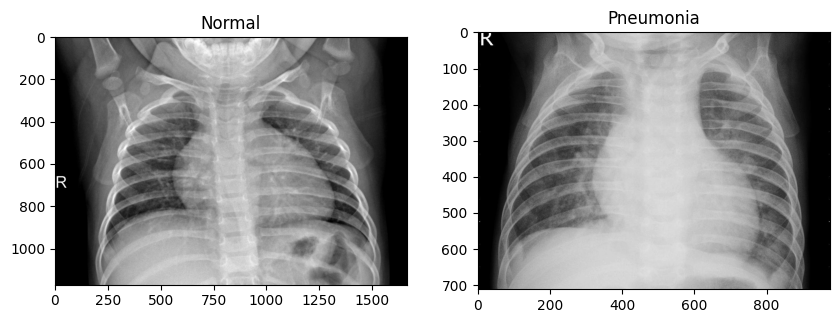

In [5]:
# plot one normal and one pneumonia image

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
img_0 = mpimg.imread(train_0[0])
img_1 = mpimg.imread(train_1[0])
ax[0].imshow(img_0, cmap='gray')
ax[0].set_title('Normal')
ax[1].imshow(img_1, cmap='gray')
ax[1].set_title('Pneumonia')
plt.show()

# Model 1 - base case

Data preprocessing
- resizing, crop to center, normalize
- no augmentation or regularization

Model
- 12 conv blocks
- ReLU activation

## Preprocessing, create dataset and dataloader

- resize to 224x224
- crop to center
- normalize



In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# create dataset
train_data = datasets.ImageFolder(root=root_train, transform=train_transform)
test_data = datasets.ImageFolder(root=root_test, transform=test_transform)

# dataloader
train_loader = DataLoader(train_data,
                          batch_size=16,
                          shuffle=True,
                          pin_memory = True)
test_loader = DataLoader(test_data,
                         batch_size=1,
                         shuffle=False,
                         pin_memory=True)

class_names = train_data.classes

print(f'Number of classes: {len(class_names)}')
print(f'Class names: {class_names}')
print(f'Number of images in train set: {len(train_data)}')
print(f'Number of images in test set: {len(test_data)}')



Number of classes: 2
Class names: ['NORMAL', 'PNEUMONIA']
Number of images in train set: 2504
Number of images in test set: 624


In [13]:
# test train_loeader and test_loeader
for data, target in train_loader:
  print(data.shape)
  print(target.shape)
  break

for data, target in test_loader:
  print(data.shape)
  print(target.shape)
  break

torch.Size([16, 3, 224, 224])
torch.Size([16])
torch.Size([1, 3, 224, 224])
torch.Size([1])


## Model

simple model from scratch
- 12 Conv blocks
- activation after each conv: ReLU
- first 3 blocks have max pooling



In [14]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in block: n. in channel = 3; n out channels = 8
    self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=0, bias = False),
                                     nn.ReLU())
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    # 1st block
    self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=0, bias = False),
                                     nn.ReLU())
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    # transition block
    self.convblock3 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=10, kernel_size=1, padding=0, bias = False),
                                     nn.ReLU())
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    # conv block
    self.convblock4 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=0, bias = False),
                                     nn.ReLU())
    self.convblock5 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=32, kernel_size=1, padding=0, bias = False),
                                     nn.ReLU())
    self.convblock6 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=10, kernel_size=1, padding=0, bias = False),
                                     nn.ReLU())
    self.convblock7 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=0, bias = False),
                                     nn.ReLU())
    self.convblock8 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=32, kernel_size=1, padding=0, bias = False),
                                     nn.ReLU())
    self.convblock9 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=10, kernel_size=1, padding=0, bias = False),
                                     nn.ReLU())
    self.convblock10 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=14, kernel_size=3, padding=0, bias = False),
                                     nn.ReLU())
    self.convblock11 = nn.Sequential(nn.Conv2d(in_channels=14, out_channels=16, kernel_size=3, padding=0, bias = False),
                                     nn.ReLU())
    # gap
    self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=4))
    # out block
    self.convblockout = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=2, kernel_size=4, padding=0, bias = False),
                                     nn.ReLU())

  def forward(self,x):
    x = self.convblock1(x)
    x = self.pool1(x)

    x = self.convblock2(x)
    x = self.pool2(x)

    x = self.convblock3(x)
    x = self.pool3(x)

    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.convblock6(x)
    x = self.convblock7(x)
    x = self.convblock8(x)
    x = self.convblock9(x)
    x = self.convblock10(x)
    x = self.convblock11(x)

    x = self.gap(x)
    x = self.convblockout(x) #final conv
    x = x.view(-1, 2) # reshape to
    return F.log_softmax(x, dim=-1)





In [16]:
#check model
model1 = SimpleCNN()
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 2]                    --
├─Sequential: 1-1                        [1, 8, 222, 222]          --
│    └─Conv2d: 2-1                       [1, 8, 222, 222]          216
│    └─ReLU: 2-2                         [1, 8, 222, 222]          --
├─MaxPool2d: 1-2                         [1, 8, 111, 111]          --
├─Sequential: 1-3                        [1, 16, 109, 109]         --
│    └─Conv2d: 2-3                       [1, 16, 109, 109]         1,152
│    └─ReLU: 2-4                         [1, 16, 109, 109]         --
├─MaxPool2d: 1-4                         [1, 16, 54, 54]           --
├─Sequential: 1-5                        [1, 10, 54, 54]           --
│    └─Conv2d: 2-5                       [1, 10, 54, 54]           160
│    └─ReLU: 2-6                         [1, 10, 54, 54]           --
├─MaxPool2d: 1-6                         [1, 10, 27, 27]           --
├─Sequenti

## Training

__Steps__
1. Initializing the gradient for the model workflow.
2. Initialize weights: the weights are randomly assigned from a distribution, using the Xavier or He initialization. (For a ReLU activation network, He is used, whereas for sigmoid, Xavier is used.)
3. Perform forward pass and compute a prediction.
4. Calculate loss.
4. Compute backward propagation given the accumulated loss.
5. Perform the optimizer step, and using the learning rate and other arguments to update the weights of the model.
7.

In [20]:
train_losses, test_losses = [], []
train_acc, test_acc = [], []

def training(model, train_loader, optimizer, epochs):
  '''
  Training function
  Inputs:
    model: model to train
    train_loader: dataloader for training
    optimizer: optimizer to use
    epochs: number of epochs to train
  Output:
    trained model
    train_losses, test_losses: list of training and testing losses
    train_acc, test_acc: list of training and testing accuracies
  '''
  # put model in training mode
  model.train()
  prog_bar = tqdm(train_loader)
  # define parameter
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(prog_bar):
    # get data
    data, target = data.to(device), target.to(device)
    # initialize gradient
    optimizer.zero_grad()
    # make prediction
    y_pred = model(data)
    # compute loss
    train_loss = F.nll_loss(y_pred, target)
    train_losses.append(train_loss.item())

    # backpropogation
    train_loss.backward()
    optimizer.step() # update weights

    # get the index of the log-probability corresponding to the max value
    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    prog_bar.set_description(desc= f'Loss={train_loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    # accuracy
    train_acc.append(100*correct/processed)
    return model, train_losses, train_acc

def testing(model, test_loader):
  # put model in evaluation mode
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      # make prediction
      output = model(data)

      # compute loss and accuracy
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    # put out a report
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return model, test_losses, test_acc



Epoch 1


Loss=0.6931473016738892 Batch_id=0 Accuracy=50.00:   0%|          | 0/157 [00:05<?, ?it/s]


learning rate: 0.01

Test set: Average loss: 0.6931, Accuracy: 226/624 (36.22%)

Epoch 2


Loss=0.6931474208831787 Batch_id=0 Accuracy=62.50:   0%|          | 0/157 [00:04<?, ?it/s]


learning rate: 0.01

Test set: Average loss: 0.6931, Accuracy: 226/624 (36.22%)

Epoch 3


Loss=0.6931473016738892 Batch_id=0 Accuracy=56.25:   0%|          | 0/157 [00:04<?, ?it/s]


learning rate: 0.01

Test set: Average loss: 0.6931, Accuracy: 226/624 (36.22%)

Epoch 4


Loss=0.6931474208831787 Batch_id=0 Accuracy=68.75:   0%|          | 0/157 [00:04<?, ?it/s]


learning rate: 0.01

Test set: Average loss: 0.6931, Accuracy: 226/624 (36.22%)

Epoch 5


Loss=0.6931473016738892 Batch_id=0 Accuracy=43.75:   0%|          | 0/157 [00:04<?, ?it/s]


learning rate: 0.01

Test set: Average loss: 0.6931, Accuracy: 226/624 (36.22%)

Final train loss: 0.69%
Final test loss: 0.69%
Final train accuracy: 43.75%
Final test accuracy: 36.22%


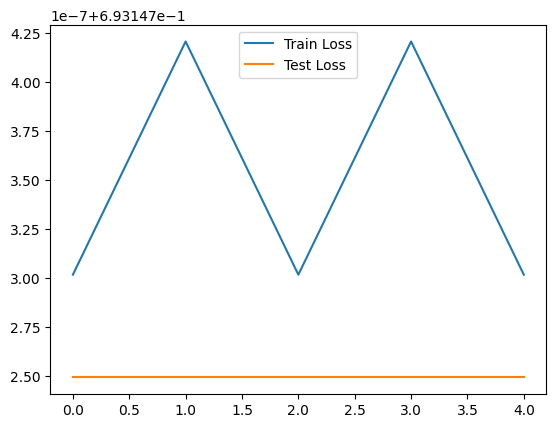

In [21]:
model1 = SimpleCNN().to(device)
#optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model1.parameters(),
                            lr = 0.01,
                            momentum = 0.9)
scheduler = StepLR(optimizer,
                   step_size = 6,
                   gamma = 0.5)
epochs = 5
for epoch in range(epochs):
  print(f'Epoch {epoch+1}')
  model1, train_losses, train_acc = training(model1, train_loader, optimizer, epochs)
  scheduler.step()
  print(f"learning rate: {optimizer.state_dict()['param_groups'][0]['lr']}")
  model1, test_losses, test_acc = testing(model1, test_loader)

print(f'Final train loss: {train_losses[-1]:.2f}%')
print(f'Final test loss: {test_losses[-1]:.2f}%')
print(f'Final train accuracy: {train_acc[-1]:.2f}%')
print(f'Final test accuracy: {test_acc[-1]:.2f}%')

# plot train and test loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

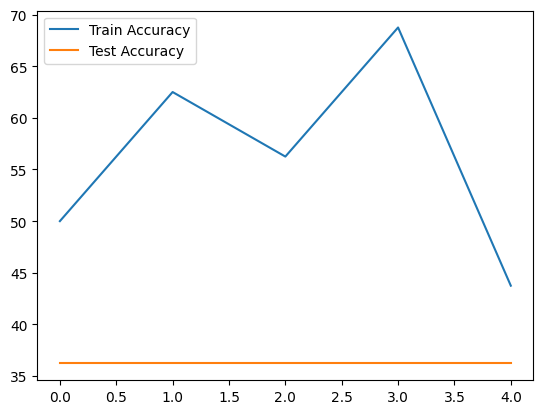

In [22]:
# plot accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.legend()
plt.show()

# Model 2

- Model architecture: same as model 1
- Preprocessing: add the following
  - Using color jitter to augment the train data.
  - Randomly flipping the train data.
  - Randomly rotating the train samples.

## Preprocessing, creating dataset and dataloader

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [ ]:
# create datasets
train_dataset = datasets.ImageFolder(root=root_train, transform=train_transform)
test_dataset = datasets.ImageFolder(root=root_test, transform=test_transforms)
# create dataloader
train_loader = DataLoader(train_dataset,
                          batch_size=16,
                          shuffle=True,
                          pin_memory=True)
test_loader = DataLoader(test_dataset,
                         batch_size=1,
                         shuffle=False,
                         pin_memory=True)

class_names = train_dataset.classes

print(class_names)
print(f"N. of images in train set: {len(train_dataset)}")
print(f"N. of images in test set: {len(test_dataset)}")

In [43]:
# check dataset
train_dataset[0][0].shape, train_dataset[0][1]

(torch.Size([3, 224, 224]), 0)

In [45]:
# check dataloader
next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

## Create model

In [38]:
import torch.nn.functional as F

class SimpleCNN_2(nn.Module):
  def __init__(self):
    super(SimpleCNN_2, self).__init__()

    # input block - also has pooling
    self.conv_block_1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                                out_channels=8,
                                                kernel_size=3,
                                                padding=0,
                                                bias=False),
                                     nn.ReLU())
    self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
    # conv blocks w/ pooling
    self.conv_block_2 = nn.Sequential(nn.Conv2d(in_channels = 8,
                                               out_channels = 16,
                                               kernel_size = 3,
                                               padding = 0,
                                               bias = False),
                                      nn.ReLU())
    self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv_block_3 = nn.Sequential(nn.Conv2d(in_channels=16,
                                               out_channels=10,
                                               kernel_size=1,
                                               padding=0,
                                               bias=False),
                                      nn.ReLU())
    self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)

    # conv blocks - no pooling
    self.conv_block_4 = nn.Sequential(nn.Conv2d(in_channels=10,
                                               out_channels=10,
                                               kernel_size=3,
                                               padding=0,
                                               bias=False),
                                      nn.ReLU())
    self.conv_block_5 = nn.Sequential(nn.Conv2d(in_channels=10,
                                               out_channels=32,
                                               kernel_size=1,
                                               padding=0,
                                               bias=False),
                                      nn.ReLU())
    self.conv_block_6 = nn.Sequential(nn.Conv2d(in_channels=32,
                                               out_channels=10,
                                               kernel_size=1,
                                               padding=0,
                                               bias=False),
                                      nn.ReLU())
    self.conv_block_7 = nn.Sequential(nn.Conv2d(in_channels = 10,
                                               out_channels = 10,
                                               kernel_size = 3,
                                               padding = 0,
                                               bias = False),
                                      nn.ReLU())
    self.conv_block_8 = nn.Sequential(nn.Conv2d(in_channels=10,
                                               out_channels=32,
                                               kernel_size=1,
                                               padding=0,
                                               bias=False),
                                      nn.ReLU())
    self.conv_block_9 = nn.Sequential(nn.Conv2d(in_channels=32,
                                               out_channels=10,
                                               kernel_size=1,
                                               padding=0,
                                               bias=False),
                                      nn.ReLU())
    self.conv_block_10 = nn.Sequential(nn.Conv2d(in_channels = 10,
                                                out_channels = 14,
                                                kernel_size = 3,
                                                padding = 0,
                                                bias = False),
                                       nn.ReLU())
    self.conv_block_11 = nn.Sequential(nn.Conv2d(in_channels=14,
                                                out_channels=16,
                                                kernel_size=3,
                                                padding=0,
                                                bias=False),
                                       nn.ReLU())
    # gap
    self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=4))
    # output block
    self.conv_block_12 = nn.Sequential(nn.Conv2d(in_channels=16,
                                                out_channels=2,
                                                kernel_size=4,
                                                padding=0,
                                                bias=False),
                                       nn.ReLU())

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.pool_1(x)

    x = self.conv_block_2(x)
    x = self.pool_2(x)

    x = self.conv_block_3(x)
    x = self.pool_3(x)

    x = self.conv_block_4(x)
    x = self.conv_block_5(x)
    x = self.conv_block_6(x)
    x = self.conv_block_7(x)
    x = self.conv_block_8(x)
    x = self.conv_block_9(x)
    x = self.conv_block_10(x)
    x = self.conv_block_11(x)

    x = self.gap(x)
    x = self.conv_block_12(x)

    x = x.view(-1, 2)
    return F.log_softmax(x, dim=-1)



In [39]:
model_2 = SimpleCNN_2().to(device)
summary(model_2, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN_2                              [1, 2]                    --
├─Sequential: 1-1                        [8, 222, 222]             --
│    └─Conv2d: 2-1                       [8, 222, 222]             216
│    └─ReLU: 2-2                         [8, 222, 222]             --
├─MaxPool2d: 1-2                         [8, 111, 111]             --
├─Sequential: 1-3                        [16, 109, 109]            --
│    └─Conv2d: 2-3                       [16, 109, 109]            1,152
│    └─ReLU: 2-4                         [16, 109, 109]            --
├─MaxPool2d: 1-4                         [16, 54, 54]              --
├─Sequential: 1-5                        [10, 54, 54]              --
│    └─Conv2d: 2-5                       [10, 54, 54]              160
│    └─ReLU: 2-6                         [10, 54, 54]              --
├─MaxPool2d: 1-6                         [10, 27, 27]              --
├─Sequenti

## Train model and perform testing

In [ ]:
train_losses, test_losses = [], []
train_acc, test_acc = [], []

def training_2 (model, device, train_loader, optimizer, epochs):
  model.train()
  training_bar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, y) in enumerate(training_bar):
    data, y = data.to(device), y.to(device)

    # initialize
    optimizer.zero_grad()
    # prediction
    y_hat = model(data)
    # compute loss
    train_loss = F.nll_loss(y_hat, y)
    train_losses.append(train_loss.item())

    # backprop.
    train_loss.backward()
    optimizer.step()

    # get the index of the max log-probability
    pred = y_hat.argmax(dim=1, keepdim=True)
    correct += pred.eq(y.view_as(pred)).sum().item()
    processed += len(data)


    training_bar.set_description(desc= f'Loss={train_loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  return model, train_losses, train_acc

def testing_2 (model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, y in test_loader:
      data, y = data.to(device), y.to(device)
      y_hat = model(data)
      test_loss += F.nll_loss(y_hat, y, reduction='sum').item()
      pred = y_hat.argmax(dim=1, keepdim=True)
      correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(100. * correct / len(test_loader.dataset))
  return model, test_losses, test_acc

In [50]:
# model_2 = SimpleCNN_2().to(device)

optimizer = torch.optim.SGD(model_2.parameters(),
                            lr = 0.01,
                            momentum = 0.9)
scheduler = StepLR(optimizer,
                   step_size = 6,
                   gamma = 0.5)

epochs = 5
for epoch in range(epochs):
  print(f'Epoch {epoch+1}')
  model_2, train_losses, train_acc = training_2(model_2,
                                                device,
                                                train_loader,
                                                optimizer,
                                                epochs)
  scheduler.step()
  print(f"learning rate: {optimizer.state_dict()['param_groups'][0]['lr']}")
  model_2, test_losses, test_acc = testing_2(model_2, device, test_loader)

Epoch 1


Loss=0.6931467056274414 Batch_id=156 Accuracy=44.97: 100%|██████████| 157/157 [11:25<00:00,  4.37s/it]


learning rate: 0.01
Epoch 2


Loss=0.6931477189064026 Batch_id=156 Accuracy=44.37: 100%|██████████| 157/157 [02:11<00:00,  1.20it/s]


learning rate: 0.01
Epoch 3


Loss=0.6931470632553101 Batch_id=156 Accuracy=44.93: 100%|██████████| 157/157 [02:15<00:00,  1.16it/s]


learning rate: 0.01
Epoch 4


Loss=0.6931473016738892 Batch_id=156 Accuracy=43.73: 100%|██████████| 157/157 [02:11<00:00,  1.19it/s]


learning rate: 0.01
Epoch 5


Loss=0.6931474804878235 Batch_id=156 Accuracy=46.69: 100%|██████████| 157/157 [02:10<00:00,  1.21it/s]


learning rate: 0.01


In [55]:
test_acc

[]

### plot results


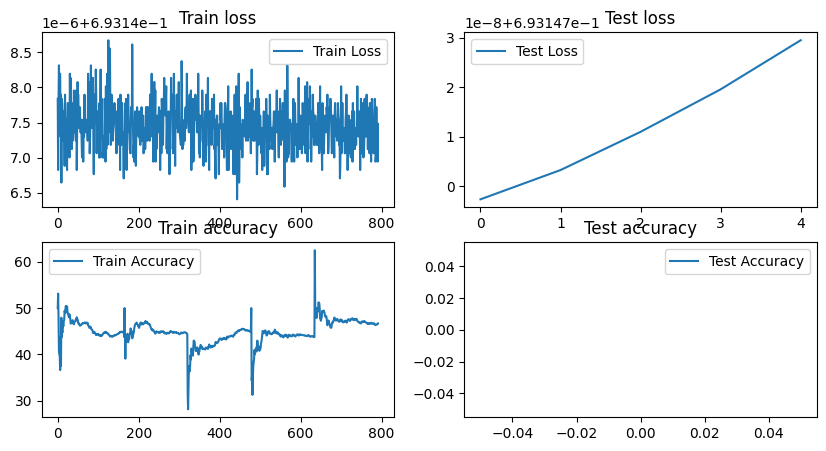

In [56]:
fig, axis = plt.subplots(2, 2, figsize=(10, 5))

# loss
axis[0, 0].plot(train_losses, label='Train Loss')
axis[0, 1].plot(test_losses, label='Test Loss')
axis[0, 0].set_title('Train loss')
axis[0, 0].legend()
axis[0, 1].set_title('Test loss')
axis[0, 1].legend()

# accuracy
axis[1, 0].plot(train_acc, label='Train Accuracy')
axis[1, 1].plot(test_acc, label='Test Accuracy')
axis[1, 0].set_title('Train accuracy')
axis[1, 0].legend()
axis[1, 1].set_title('Test accuracy')
axis[1, 1].legend()

plt.show()


# Model

Model architecture - following changes to model 1
- 11 conv blocks and 3 pooling layers
- added batch normalization after each layer to all channels


## Define dataset, dataloader, and augmentations

In [ ]:
# train_transform and test_transform are the same
train_transofrm = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.CenterCrop(224),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.2),
                                      transforms.RandomHorizontalFlip(p=0.1),
                                      transforms.RandomRotation(degrees=20),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                      ])
test_transform = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                      ])



## Create model w/ batch normalization

In [70]:
class SimpleCNN_3(nn.Module):
  def __init__(self, num_classes):
    super(SimpleCNN_3, self).__init__()

    # in conv block w/ pooling
    self.num_classes = num_classes
    self.conv_block_1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                                out_channels=8,
                                                kernel_size=3,
                                                padding=0,
                                                bias=False),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(8))
    self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

    # conv block with pooling
    self.conv_block_2 = nn.Sequential(nn.Conv2d(in_channels=8,
                                                out_channels=16,
                                                kernel_size=3,
                                                padding=0,
                                                bias=False),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(16))
    self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv_block_3 = nn.Sequential(nn.Conv2d(in_channels=16,
                                                out_channels=10,
                                                kernel_size=1,
                                                padding=0,
                                                bias=False),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(10))
    self.pool_3 = nn.MaxPool2d(kernel_size = 2, stride=2)

    # conv blocks w/o pooling
    self.conv_block_4 = nn.Sequential(nn.Conv2d(in_channels=10,
                                                out_channels=10,
                                                kernel_size=3,
                                                padding=0,
                                                bias=False),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(10))
    self.conv_block_5 = nn.Sequential(nn.Conv2d(in_channels=10,
                                                out_channels=32,
                                                kernel_size=1,
                                                padding=0,
                                                bias=False),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(32))
    self.conv_block_6 = nn.Sequential(nn.Conv2d(in_channels=32,
                                                out_channels=10,
                                                kernel_size=1,
                                                padding=0,
                                                bias=False),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(10))
    self.conv_block_7 = nn.Sequential(nn.Conv2d(in_channels = 10,
                                               out_channels = 10,
                                               kernel_size = 3, padding = 0,
                                               bias = False),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(10))
    self.conv_block_8 = nn.Sequential(nn.Conv2d(in_channels=10,
                                                out_channels=32,
                                                kernel_size=1,
                                                padding=0,
                                                bias=False),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(32))
    self.conv_block_9 = nn.Sequential(nn.Conv2d(in_channels=32,
                                                out_channels = 10,
                                                kernel_size = 1,
                                                padding = 0,
                                                bias = False),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(10))
    self.conv_block_10 = nn.Sequential(nn.Conv2d(in_channels=10,
                                                 out_channels = 14,
                                                 kernel_size = 3,
                                                 padding = 0,
                                                 bias = False),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(14))
    self.conv_block_11 = nn.Sequential(nn.Conv2d(in_channels=14,
                                                 out_channels=16,
                                                 kernel_size=3,
                                                 padding = 0,
                                                 bias = False),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(16))

    # gao
    self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=4))
    # out conv
    self.conv_block_12 = nn.Sequential(nn.Conv2d(in_channels=16,
                                                out_channels=self.num_classes,
                                                kernel_size=4,
                                                padding=0,
                                                bias=False),
                                       )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.pool_1(x)
    x = self.conv_block_2(x)
    x = self.pool_2(x)
    x = self.conv_block_3(x)
    x = self.pool_3(x)
    x = self.conv_block_4(x)
    x = self.conv_block_5(x)
    x = self.conv_block_6(x)
    x = self.conv_block_7(x)
    x = self.conv_block_8(x)
    x = self.conv_block_9(x)
    x = self.conv_block_10(x)
    x = self.conv_block_11(x)

    x = self.gap(x)
    x = self.conv_block_12(x)
    x = x.view(-1, self.num_classes)
    return F.log_softmax(x, dim=-1)

# check model
summary(SimpleCNN_3(2).to(device), input_size=(1,3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN_3                              [1, 2]                    --
├─Sequential: 1-1                        [1, 8, 222, 222]          --
│    └─Conv2d: 2-1                       [1, 8, 222, 222]          216
│    └─ReLU: 2-2                         [1, 8, 222, 222]          --
│    └─BatchNorm2d: 2-3                  [1, 8, 222, 222]          16
├─MaxPool2d: 1-2                         [1, 8, 111, 111]          --
├─Sequential: 1-3                        [1, 16, 109, 109]         --
│    └─Conv2d: 2-4                       [1, 16, 109, 109]         1,152
│    └─ReLU: 2-5                         [1, 16, 109, 109]         --
│    └─BatchNorm2d: 2-6                  [1, 16, 109, 109]         32
├─MaxPool2d: 1-4                         [1, 16, 54, 54]           --
├─Sequential: 1-5                        [1, 10, 54, 54]           --
│    └─Conv2d: 2-7                       [1, 10, 54, 54]           160
│    └─ReL

## TRaining and evaluation - plot the loss and accuracy

In [ ]:
def training_3 (model, device, train_loader, optimizer, epochs):
  train_losses, train_acc = [], []
  model.train()
  process_bar = tqdm(train_loader)

  correct, processed = 0, 0
  for batch_idx, (data, y) in enumerate(process_bar):
    X, y = data.to(device), y.to(device)

    # initialize
    optimizer.zero_grad()
    # prediction
    y_hat = model(X)
    # compute loss
    train_loss = F.nll_loss(y_hat, y)
    train_losses.append(train_loss.item())

    #backprop.
    train_loss.backward()
    optimizer.step()

    # get the index of the max log-probability
    pred = y_hat.argmax(dim=1, keepdim=True)
    correct += pred.eq(y.view_as(pred)).sum().item()
    processed += len(X)

    pred = y_hat.argmax(dim=1, keepdim = True) # get the index of the mx log_prob.
    correct += pred.eq(y.view_as(pred)).sum().item()
    processed += len(X)

    process_bar.set_description(desc= f'Loss={train_loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  return train_losses, train_acc

def evaluation(model, device, test_loader):
  model.eval()
  test_losses = []
  test_acc = []
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for X,y in test_loader:
      X, y = X.to(device), y.to(device)
      y_hat = model(X)

      y_hat = model(X)
      test_loss += F.nll_loss(y_hat, y, reduction='sum').item()
      pred = y_hat.argmax(dim=1, keepdim=True)
      correct += pred.eq(y.view_as(pred)).sum().item()

      test_loss /= len(test_loader.dataset)
      test_losses.append(test_loss)
      test_acc.append(100. * correct / len(test_loader.dataset))
  print ('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

  return test_losses, test_acc

In [92]:
model_3 = SimpleCNN_3(2).to(device)

optimizer = torch.optim.SGD(model_3.parameters(),
                            lr = 0.01,
                            momentum = 0.9)
scheduler = StepLR(optimizer,
                   step_size = 6,
                   gamma = 0.5)

epochs = 10
for epoch in range(epochs):
  print(f'Epoch {epoch+1}')
  train_losses, train_acc = training_3(model_3,
                                       device,
                                       train_loader,
                                       optimizer,
                                       epochs)
  scheduler.step()
  print(f"learning rate: {optimizer.state_dict()['param_groups'][0]['lr']}")
  test_losses, test_acc = evaluation(model_3, device, test_loader)



Epoch 1


Loss=0.30991530418395996 Batch_id=78 Accuracy=80.27: 100%|██████████| 79/79 [02:31<00:00,  1.92s/it]


learning rate: 0.01
Test set: Average loss: 0.8447, Accuracy: 314/624 (50.32%)

Test set: Average loss: 0.8447, Accuracy: 314/624 (50.32%)

Epoch 2


Loss=0.23351797461509705 Batch_id=78 Accuracy=89.06: 100%|██████████| 79/79 [02:32<00:00,  1.93s/it]


learning rate: 0.01
Test set: Average loss: 0.9099, Accuracy: 390/624 (62.50%)

Test set: Average loss: 0.9099, Accuracy: 390/624 (62.50%)

Epoch 3


Loss=0.5315595269203186 Batch_id=78 Accuracy=89.62: 100%|██████████| 79/79 [02:30<00:00,  1.91s/it]


learning rate: 0.01
Test set: Average loss: 1.1537, Accuracy: 390/624 (62.50%)

Test set: Average loss: 1.1537, Accuracy: 390/624 (62.50%)

Epoch 4


Loss=0.19146160781383514 Batch_id=78 Accuracy=90.97: 100%|██████████| 79/79 [02:30<00:00,  1.90s/it]


learning rate: 0.01
Test set: Average loss: 1.1365, Accuracy: 393/624 (62.98%)

Test set: Average loss: 1.1365, Accuracy: 393/624 (62.98%)

Epoch 5


Loss=0.21828891336917877 Batch_id=78 Accuracy=91.93: 100%|██████████| 79/79 [02:33<00:00,  1.94s/it]


learning rate: 0.01
Test set: Average loss: 0.9216, Accuracy: 391/624 (62.66%)

Test set: Average loss: 0.9216, Accuracy: 391/624 (62.66%)

Epoch 6


Loss=0.24196143448352814 Batch_id=78 Accuracy=92.13: 100%|██████████| 79/79 [02:30<00:00,  1.90s/it]


learning rate: 0.005
Test set: Average loss: 0.9049, Accuracy: 390/624 (62.50%)

Test set: Average loss: 0.9049, Accuracy: 390/624 (62.50%)

Epoch 7


Loss=0.01510562002658844 Batch_id=78 Accuracy=93.77: 100%|██████████| 79/79 [02:30<00:00,  1.91s/it]


learning rate: 0.005
Test set: Average loss: 0.9282, Accuracy: 390/624 (62.50%)

Test set: Average loss: 0.9282, Accuracy: 390/624 (62.50%)

Epoch 8


Loss=0.22745414078235626 Batch_id=78 Accuracy=94.89: 100%|██████████| 79/79 [02:30<00:00,  1.90s/it]


learning rate: 0.005
Test set: Average loss: 0.7069, Accuracy: 384/624 (61.54%)

Test set: Average loss: 0.7069, Accuracy: 384/624 (61.54%)

Epoch 9


Loss=0.2621467709541321 Batch_id=78 Accuracy=95.01: 100%|██████████| 79/79 [02:28<00:00,  1.89s/it]


learning rate: 0.005
Test set: Average loss: 0.7692, Accuracy: 386/624 (61.86%)

Test set: Average loss: 0.7692, Accuracy: 386/624 (61.86%)

Epoch 10


Loss=0.3033584952354431 Batch_id=78 Accuracy=94.65: 100%|██████████| 79/79 [02:31<00:00,  1.92s/it]


learning rate: 0.005
Test set: Average loss: 0.8820, Accuracy: 388/624 (62.18%)

Test set: Average loss: 0.8820, Accuracy: 388/624 (62.18%)



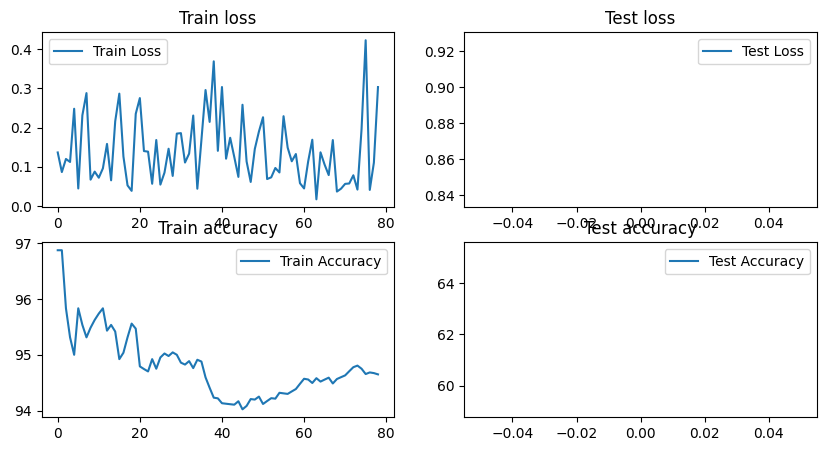

In [94]:
# Plot results
fig,axis = plt.subplots(2, 2, figsize=(10, 5))

# loss
axis[0, 0].plot(train_losses, label='Train Loss')
axis[0, 1].plot(test_losses, label='Test Loss')
axis[0, 0].set_title('Train loss')
axis[0, 0].legend()
axis[0, 1].set_title('Test loss')
axis[0, 1].legend()

# accuracy
axis[1, 0].plot(train_acc, label='Train Accuracy')
axis[1, 1].plot(test_acc, label='Test Accuracy')
axis[1, 0].set_title('Train accuracy')
axis[1, 0].legend()
axis[1, 1].set_title('Test accuracy')
axis[1, 1].legend()

plt.show()

# Model 4 - add regularization

Model architecture
- same as model 3 (conv + batch normalization)

Preprocessing
- same as model 3 (augmentation)

Training and testing
- NEW: added regularization

## Preprocess, create dataset and dataloader
- data augmentation

In [95]:
# augmentation
train_transform = transforms.Compose([
    transforms.Resize((224,22)),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transfrom = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                     ])

In [ ]:
train_dataset = datasets.ImageFolder(root_train, transform=train_transform)
test_dataset = datasets.ImageFolder(root_test, transform=test_transform)

# data loader
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=32,
                                           shuffle=True,
                                           pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=1,
                                          shuffle=False,
                                          pin_memory=True)

# test dataset and dataloader
print (train_dataset[0][0].shape)

next(iter(train_loader))[0].shape

## Create model

In [98]:
class SimpleCNN_4(nn.Module):
  def __init__(self, num_classes):
    super(SimpleCNN_4, self).__init__()
    self.num_classes = num_classes

    # input conv
    self.conv_block_1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                                out_channels=8,
                                                kernel_size=3,
                                                padding=0,
                                                bias=False),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(8))
    self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
    # conv blocks w/pool
    self.conv_block_2 = nn.Sequential(nn.Conv2d(in_channels=8,
                                                out_channels=16,
                                                kernel_size=3,
                                                padding=0,
                                                bias=False),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(16))
    self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv_block_3 = nn.Sequential(nn.Conv2d(in_channels = 16,
                                                out_channels=10,
                                                kernel_size=1,
                                                padding = 0,
                                                bias = False),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(10))
    self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)

    # blocks w/o pool;
    self.conv_block_4 = nn.Sequential(nn.Conv2d(in_channels=10,
                                                out_channels=10,
                                                kernel_size=3,
                                                padding=0,
                                                bias=False),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(10))
    self.conv_block_5 = nn.Sequential(nn.Conv2d(in_channels=10,
                                                out_channels=32,
                                                kernel_size=1,
                                                padding=0,
                                                bias=False),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(32))
    self.conv_block_6 = nn.Sequential(nn.Conv2d(in_channels=32,
                                                out_channels=10,
                                                kernel_size=1,
                                                padding=0,
                                                bias=False),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(10))
    self.conv_block_7 = nn.Sequential(nn.Conv2d(in_channels=10,
                                                out_channels=10,
                                                kernel_size=3,
                                                padding=0,
                                                bias=False),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(10))
    self.conv_block_8 = nn.Sequential(nn.Conv2d(in_channels=10,
                                                out_channels=32,
                                                padding=0,
                                                kernel_size=1,
                                                bias=False),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(32))
    self.conv_block_9 = nn.Sequential(nn.Conv2d(in_channels=32,
                                                out_channels=10,
                                                kernel_size=1,
                                                padding=0,
                                                bias=False),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(10))
    self.conv_block_10 = nn.Sequential(nn.Conv2d(in_channels=10,
                                                 out_channels=14,
                                                 kernel_size=
                                                 3,
                                                 padding=0,
                                                 bias=False),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(14))
    self.conv_block_11 = nn.Sequential(nn.Conv2d(in_channels = 14,
                                                 out_channels = 16,
                                                 kernel_size = 3,
                                                 padding = 0,
                                                 bias = False),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(16))

    self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=4))
    # out conv
    self.conv_block_12 = nn.Sequential(nn.Conv2d(in_channels=16,
                                                 out_channels=self.num_classes,
                                                 kernel_size=4,
                                                 padding=0,
                                                 bias=False),
                                       )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.pool_1(x)
    x = self.conv_block_2(x)
    x = self.pool_2(x)
    x = self.conv_block_3(x)
    x = self.pool_3(x)

    x = self.conv_block_4(x)
    x = self.conv_block_5(x)
    x = self.conv_block_6(x)
    x = self.conv_block_7(x)
    x = self.conv_block_8(x)
    x = self.conv_block_9(x)
    x = self.conv_block_10(x)
    x = self.conv_block_11(x)

    x = self.gap(x)
    x = self.conv_block_12(x)

    x = x.view(-1, self.num_classes)
    return F.log_softmax(x, dim=-1)

# test model
summary(SimpleCNN_4(2).to(device), input_size=(1,3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN_4                              [1, 2]                    --
├─Sequential: 1-1                        [1, 8, 222, 222]          --
│    └─Conv2d: 2-1                       [1, 8, 222, 222]          216
│    └─ReLU: 2-2                         [1, 8, 222, 222]          --
│    └─BatchNorm2d: 2-3                  [1, 8, 222, 222]          16
├─MaxPool2d: 1-2                         [1, 8, 111, 111]          --
├─Sequential: 1-3                        [1, 16, 109, 109]         --
│    └─Conv2d: 2-4                       [1, 16, 109, 109]         1,152
│    └─ReLU: 2-5                         [1, 16, 109, 109]         --
│    └─BatchNorm2d: 2-6                  [1, 16, 109, 109]         32
├─MaxPool2d: 1-4                         [1, 16, 54, 54]           --
├─Sequential: 1-5                        [1, 10, 54, 54]           --
│    └─Conv2d: 2-7                       [1, 10, 54, 54]           160
│    └─ReL

## Training and evaluation - include regularization


In [ ]:
def training_4 (model, device, train_loader, optimizer, epochs):
  train_losses, train_acc = [], []
  model.train()
  process_bar = tqdm(train_loader)
  alpha = 0.0001

  correct, processed = 0, 0
  for batch_idx, (data, y) in enumerate(process_bar):
    X, y = data.to(device), y.to(device)

    # initialize
    optimizer.zero_grad()
    # prediction
    y_hat = model(X)
    # compute loss
    train_loss = F.nll_loss(y_hat, y)

    # regularization =================================
    l1 = 0
    for p in model.parameters():
      l1 = l1 + p.abs().sum()
    train_loss += alpha * l1

    train_losses.append(train_loss.item())

    #backprop.
    train_loss.backward()
    optimizer.step()

    pred = y_hat.argmax(dim=1, keepdim=True)
    correct += pred.eq(y.view_as(pred)).sum().item()
    processed += len(X)

    process_bar.set_description(desc= f'Loss={train_loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  return train_losses, train_acc

def evaluation_4 (model, device, test_loader):
  model.eval()
  test_losses = []
  test_acc = []
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for X,y in test_loader:
      X, y = X.to(device), y.to(device)
      y_hat = model(X)

      test_loss += F.nll_loss(y_hat, y, reduction='sum').item()
      pred = y_hat.argmax(dim=1, keepdim=True)
      correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(100. * correct / len(test_loader.dataset))


  print ('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))


  return test_losses, test_acc

In [107]:
model_4 = SimpleCNN_4(2).to(device)

optimizer = torch.optim.SGD(model_4.parameters(),
                            lr = 0.01,
                            momentum = 0.9)
scheduler = StepLR(optimizer, step_size = 6, gamma = 0.5)

epochs = 10

for epoch in range(epochs):
  print(f'Epoch {epoch+1}')
  train_losses, train_acc = training_4(model_4,
                                       device,
                                       train_loader,
                                       optimizer,
                                       epochs)

  scheduler.step()
  print(f"learning rate: {optimizer.state_dict()['param_groups'][0]['lr']}")

  test_losses, test_acc = evaluation_4(model_4, device, test_loader)


Epoch 1


Loss=0.4874125123023987 Batch_id=78 Accuracy=78.19: 100%|██████████| 79/79 [02:32<00:00,  1.94s/it]


learning rate: 0.01
Test set: Average loss: 1.2805, Accuracy: 389/624 (62.34%)

Epoch 2


Loss=0.16363295912742615 Batch_id=78 Accuracy=89.02: 100%|██████████| 79/79 [02:30<00:00,  1.90s/it]


learning rate: 0.01
Test set: Average loss: 2.8625, Accuracy: 390/624 (62.50%)

Epoch 3


Loss=0.1574038565158844 Batch_id=78 Accuracy=90.38: 100%|██████████| 79/79 [02:29<00:00,  1.90s/it]


learning rate: 0.01
Test set: Average loss: 1.7334, Accuracy: 392/624 (62.82%)

Epoch 4


Loss=0.2836974263191223 Batch_id=78 Accuracy=92.05: 100%|██████████| 79/79 [02:31<00:00,  1.92s/it]


learning rate: 0.01
Test set: Average loss: 1.0201, Accuracy: 315/624 (50.48%)

Epoch 5


Loss=0.23339423537254333 Batch_id=78 Accuracy=92.13: 100%|██████████| 79/79 [02:35<00:00,  1.97s/it]


learning rate: 0.01
Test set: Average loss: 1.6738, Accuracy: 239/624 (38.30%)

Epoch 6


Loss=1.272483229637146 Batch_id=78 Accuracy=93.85: 100%|██████████| 79/79 [02:30<00:00,  1.91s/it]


learning rate: 0.005
Test set: Average loss: 2.1937, Accuracy: 202/624 (32.37%)

Epoch 7


Loss=0.1090213805437088 Batch_id=78 Accuracy=93.25: 100%|██████████| 79/79 [02:29<00:00,  1.90s/it]


learning rate: 0.005
Test set: Average loss: 1.8706, Accuracy: 225/624 (36.06%)

Epoch 8


Loss=0.10066144168376923 Batch_id=78 Accuracy=94.61: 100%|██████████| 79/79 [02:29<00:00,  1.90s/it]


learning rate: 0.005
Test set: Average loss: 1.7805, Accuracy: 268/624 (42.95%)

Epoch 9


Loss=0.11162649095058441 Batch_id=78 Accuracy=94.89: 100%|██████████| 79/79 [02:30<00:00,  1.90s/it]


learning rate: 0.005
Test set: Average loss: 1.6433, Accuracy: 350/624 (56.09%)

Epoch 10


Loss=0.08704569190740585 Batch_id=78 Accuracy=94.33: 100%|██████████| 79/79 [02:32<00:00,  1.93s/it]


learning rate: 0.005
Test set: Average loss: 1.7112, Accuracy: 367/624 (58.81%)



### Plot outputs

[58.81410256410256]

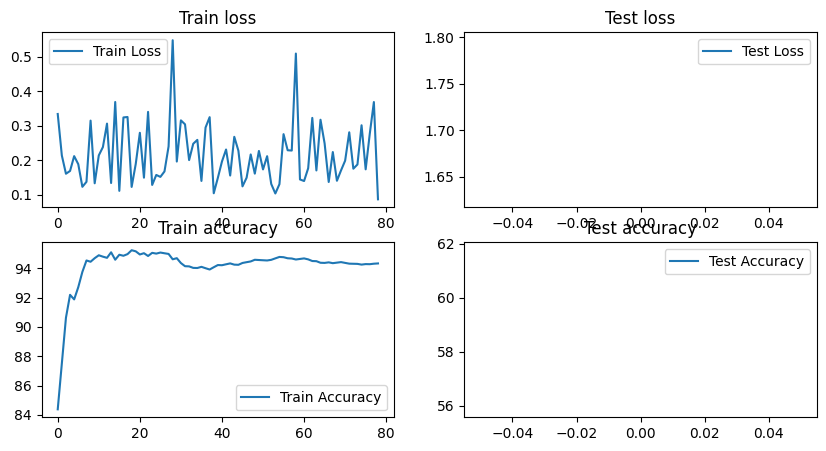

In [108]:
# Plot results
fig,axis = plt.subplots(2, 2, figsize=(10, 5))

# loss
axis[0, 0].plot(train_losses, label='Train Loss')
axis[0, 1].plot(test_losses, label='Test Loss')
axis[0, 0].set_title('Train loss')
axis[0, 0].legend()
axis[0, 1].set_title('Test loss')
axis[0, 1].legend()

# accuracy
axis[1, 0].plot(train_acc, label='Train Accuracy')
axis[1, 1].plot(test_acc, label='Test Accuracy')
axis[1, 0].set_title('Train accuracy')
axis[1, 0].legend()
axis[1, 1].set_title('Test accuracy')
axis[1, 1].legend()

plt.show()